In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Load Parquet

In [ ]:
attributes = pd.read_parquet("datasets/attributes_multihot.parquet")
categories = pd.read_parquet("datasets/categories_multihot.parquet")
reviews_embedding = pd.read_parquet("datasets/restaurant_reviews_pooled_embeddings.parquet")

In [ ]:
attributes

,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.street,BusinessParking.validated,BusinessParking.lot,BusinessParking.valet,BikeParking,RestaurantsPriceRange2_1,...,AgesAllowed_18plus,AgesAllowed_21plus,AgesAllowed_allages,DietaryRestrictions.dairy-free,DietaryRestrictions.gluten-free,DietaryRestrictions.vegan,DietaryRestrictions.halal,DietaryRestrictions.soy-free,DietaryRestrictions.vegetarian,AcceptsInsurance
0,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51217,1,0,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
51218,0,1,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
51219,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
51220,0,0,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


# Inferred function

In [ ]:
def inferred_function(hypothesis_values = dict, df_embeddings = pd.DataFrame):

    # Load model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Detect device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Coding hypotheses
    hypothesis_texts = list(hypothesis_values.values())
    hypothesis_embeddings = model.encode(hypothesis_texts, convert_to_tensor=True).to(device)

    # Convert embeddings to tensor
    restaurant_embeddings = torch.tensor(df_embeddings.values, dtype=torch.float).to(device)

    # Calculte similarity
    cosine_scores = util.cos_sim(restaurant_embeddings, hypothesis_embeddings)

    # Threshold for deciding whether the attribute applies
    threshold = 0.4 # 40%
    predictions = (cosine_scores >= threshold).int()

    # Creat DataFrame
    attribute_names = list(hypothesis_values.keys())
    df_predictions = pd.DataFrame(predictions.cpu().numpy(), columns=attribute_names)

    return df_predictions


# 1. atributes

## 1.1 Apply inferred_function

In [ ]:
hypothesis_attributes = {
    'RestaurantsDelivery': "This restaurant offers delivery.",
    'OutdoorSeating': "This restaurant has outdoor seating.",
    'BusinessAcceptsCreditCards': "This business accepts credit cards.",
    'BusinessParking.garage': "This business has a parking garage.",
    'BusinessParking.street': "This business has street parking.",
    'BusinessParking.validated': "This business offers validated parking.",
    'BusinessParking.lot': "This business has a parking lot.",
    'BusinessParking.valet': "This business offers valet parking.",
    'BikeParking': "There is parking space for bikes.",
    'RestaurantsPriceRange2_1': "This restaurant has a price range of 1 (e.g., $).",
    'RestaurantsPriceRange2_2': "This restaurant has a price range of 2 (e.g., $$).",
    'RestaurantsPriceRange2_3': "This restaurant has a price range of 3 (e.g., $$$).",
    'RestaurantsPriceRange2_4': "This restaurant has a price range of 4 (e.g., $$$$).",
    'RestaurantsTakeOut': "This restaurant offers takeout.",
    'ByAppointmentOnly': "You can only visit this business by appointment.",
    'WiFi_free': "This place offers free Wi-Fi.",
    'WiFi_no': "This place does not offer Wi-Fi.",
    'WiFi_paid': "This place offers paid Wi-Fi.",
    'Alcohol_beer_and_wine': "This place serves beer and wine only.",
    'Alcohol_full_bar': "This place has a full bar.",
    'Caters': "This business offers catering services.",
    'RestaurantsAttire_casual': "This restaurant has a casual dress code.",
    'RestaurantsAttire_dressy': "This restaurant has a dressy dress code.",
    'RestaurantsAttire_formal': "This restaurant has a formal dress code.",
    'RestaurantsReservations': "Reservations are accepted at this restaurant.",
    'GoodForKids': "This place is good for kids.",
    'CoatCheck': "This place offers coat check.",
    'DogsAllowed': "Dogs are allowed at this place.",
    'RestaurantsTableService': "This restaurant offers table service.",
    'RestaurantsGoodForGroups': "This restaurant is good for groups.",
    'WheelchairAccessible': "This business is wheelchair accessible.",
    'HasTV': "This place has a TV.",
    'HappyHour': "This place has a happy hour.",
    'DriveThru': "This business has a drive-thru.",
    'NoiseLevel_average': "The noise level at this place is average.",
    'NoiseLevel_loud': "The noise level at this place is loud.",
    'NoiseLevel_quiet': "The noise level at this place is quiet.",
    'NoiseLevel_very_loud': "The noise level at this place is very loud.",
    'Ambience.romantic': "This place has a romantic ambience.",
    'Ambience.intimate': "This place has an intimate ambience.",
    'Ambience.touristy': "This place has a touristy ambience.",
    'Ambience.hipster': "This place has a hipster ambience.",
    'Ambience.divey': "This place has a divey ambience.",
    'Ambience.classy': "This place has a classy ambience.",
    'Ambience.trendy': "This place has a trendy ambience.",
    'Ambience.upscale': "This place has an upscale ambience.",
    'Ambience.casual': "This place has a casual ambience.",
    'GoodForMeal.dessert': "This place is good for dessert.",
    'GoodForMeal.latenight': "This place is good for late-night meals.",
    'GoodForMeal.lunch': "This place is good for lunch.",
    'GoodForMeal.dinner': "This place is good for dinner.",
    'GoodForMeal.brunch': "This place is good for brunch.",
    'GoodForMeal.breakfast': "This place is good for breakfast.",
    'BusinessAcceptsBitcoin': "This business accepts Bitcoin.",
    'Smoking_no': "Smoking is not allowed at this place.",
    'Smoking_outdoor': "Smoking is only allowed outdoors at this place.",
    'Smoking_yes': "Smoking is allowed at this place.",
    'Music.dj': "This place has a DJ.",
    'Music.background_music': "This place plays background music.",
    'Music.jukebox': "This place has a jukebox.",
    'Music.live': "This place has live music.",
    'Music.video': "This place has music videos.",
    'Music.karaoke': "This place has karaoke.",
    'GoodForDancing': "This place is good for dancing.",
    'BestNights.monday': "This place is popular on Mondays.",
    'BestNights.tuesday': "This place is popular on Tuesdays.",
    'BestNights.friday': "This place is popular on Fridays.",
    'BestNights.wednesday': "This place is popular on Wednesdays.",
    'BestNights.thursday': "This place is popular on Thursdays.",
    'BestNights.sunday': "This place is popular on Sundays.",
    'BestNights.saturday': "This place is popular on Saturdays.",
    'BYOB': "This place allows BYOB (Bring Your Own Bottle).",
    'Corkage': "This place charges a corkage fee.",
    'BYOBCorkage_no': "This place does not allow BYOB or charge corkage.",
    'BYOBCorkage_yes_corkage': "This place allows BYOB with a corkage fee.",
    'BYOBCorkage_yes_free': "This place allows BYOB for free.",
    'RestaurantsCounterService': "This restaurant offers counter service.",
    'Open24Hours': "This business is open 24 hours.",
    'AgesAllowed_18plus': "Only ages 18 and older are allowed at this place.",
    'AgesAllowed_21plus': "Only ages 21 and older are allowed at this place.",
    'AgesAllowed_allages': "All ages are allowed at this place.",
    'DietaryRestrictions.dairy-free': "This place offers dairy-free options.",
    'DietaryRestrictions.gluten-free': "This place offers gluten-free options.",
    'DietaryRestrictions.vegan': "This place offers vegan options.",
    'DietaryRestrictions.halal': "This place offers halal options.",
    'DietaryRestrictions.soy-free': "This place offers soy-free options.",
    'DietaryRestrictions.vegetarian': "This place offers vegetarian options.",
    'AcceptsInsurance': "This business accepts insurance."
}

In [ ]:
inferred_attributes = inferred_function(hypothesis_attributes, reviews_embedding)

In [ ]:
inferred_attributes

,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.street,BusinessParking.validated,BusinessParking.lot,BusinessParking.valet,BikeParking,RestaurantsPriceRange2_1,...,AgesAllowed_18plus,AgesAllowed_21plus,AgesAllowed_allages,DietaryRestrictions.dairy-free,DietaryRestrictions.gluten-free,DietaryRestrictions.vegan,DietaryRestrictions.halal,DietaryRestrictions.soy-free,DietaryRestrictions.vegetarian,AcceptsInsurance
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51219,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
51220,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## 1.2 Show results

In [ ]:
total_columns = attributes.columns
results = []

for column in total_columns:
    y_tab = attributes[column]
    y_inferred = inferred_attributes[column]

    predicted = ((y_inferred != y_tab) & y_inferred).sum()
    non_predicted = ((y_inferred != y_tab) & y_tab).sum()

    results.append({
        "Attribute": column,
        "New_values_predicted": predicted,
        "Non_Predicted": non_predicted,
        "Percentage_Predicted": round(predicted / len(y_inferred) * 100, 2),
        "Percentage_Non_Predicted": round(non_predicted / len(y_inferred) * 100, 2)
    })

df_results = pd.DataFrame(results)


In [ ]:
df_results.sort_values("New_values_predicted", ascending=False)

,Attribute,New_values_predicted,Non_Predicted,Percentage_Predicted,Percentage_Non_Predicted
48,GoodForMeal.latenight,43292,80,84.52,0.16
12,RestaurantsPriceRange2_4,41363,40,80.75,0.08
11,RestaurantsPriceRange2_3,39963,159,78.02,0.31
47,GoodForMeal.dessert,36973,172,72.18,0.34
50,GoodForMeal.dinner,32487,64,63.42,0.12
...,...,...,...,...,...
75,BYOBCorkage_yes_free,0,584,0.00,1.14
78,AgesAllowed_18plus,0,1,0.00,0.00
73,BYOBCorkage_no,0,738,0.00,1.44
74,BYOBCorkage_yes_corkage,0,101,0.00,0.20


In [ ]:
df_sorted = df_results.sort_values("New_values_predicted", ascending=False)
x = range(len(df_sorted["Attribute"]))

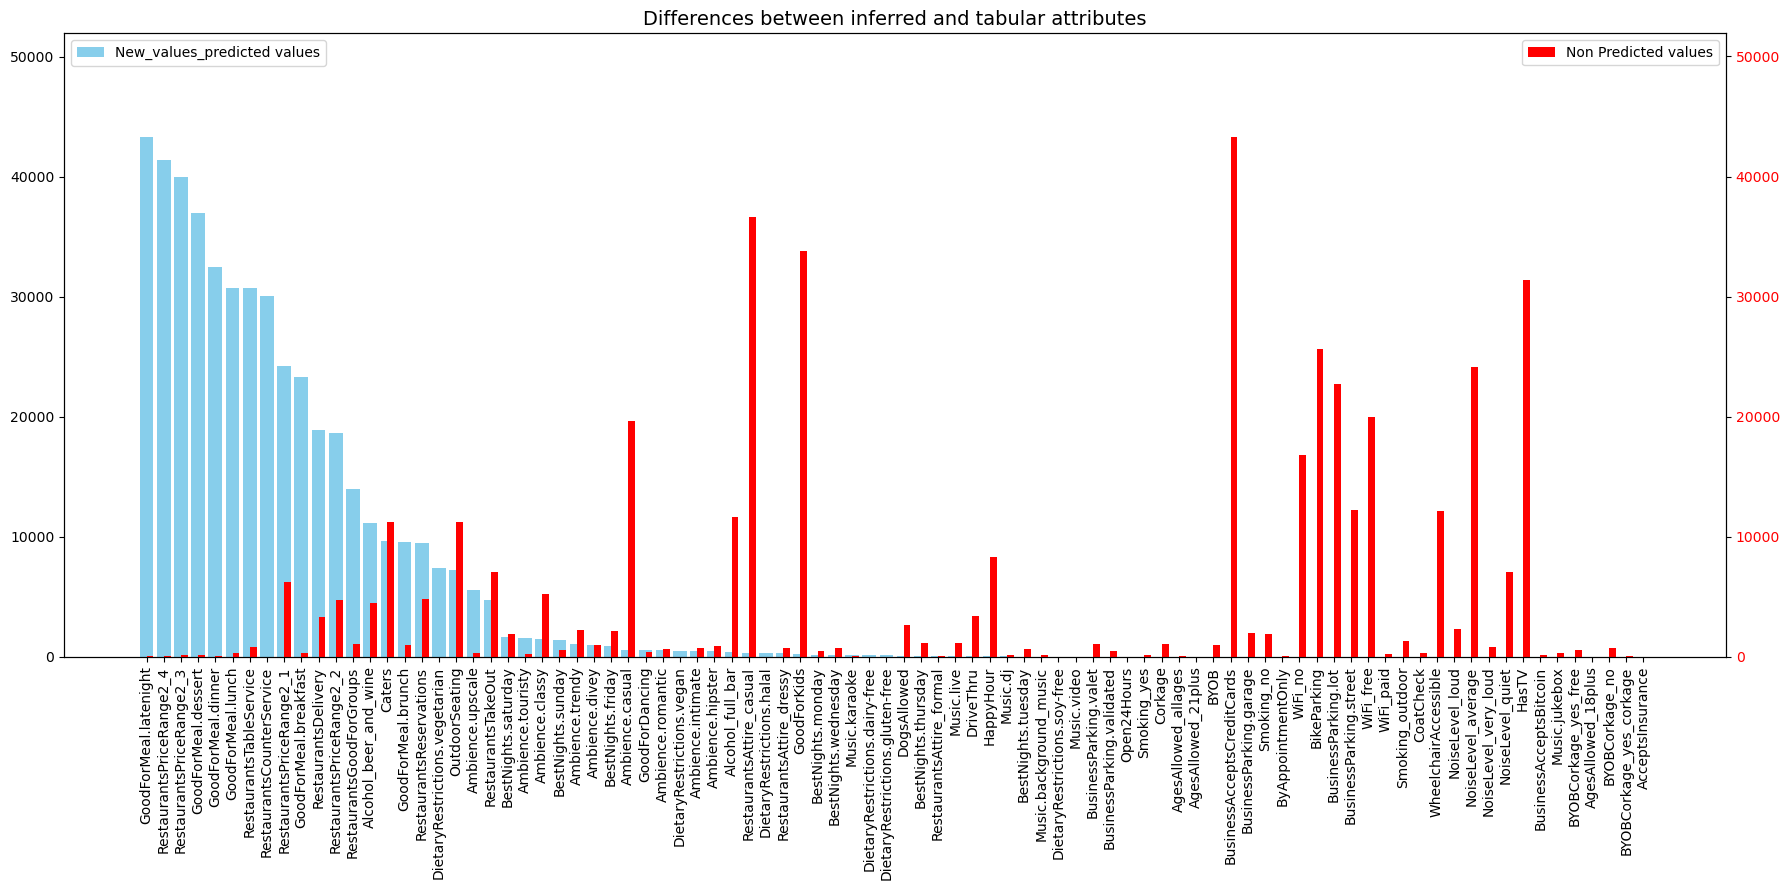

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 9))

bars = ax1.bar(x, df_sorted["New_values_predicted"], color='skyblue', label='New_values_predicted values')
ax1.set_ylim(0, max(df_sorted["New_values_predicted"]) * 1.2)

ax2 = ax1.twinx()
bars2 = ax2.bar([i + 0.2 for i in x], df_sorted["Non_Predicted"], width=0.4, color='red', label='Non Predicted values')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(df_sorted["Non_Predicted"]) * 1.2)

ax1.set_xticks(x)
ax1.set_xticklabels(df_sorted["Attribute"], rotation=90)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Differences between inferred and tabular attributes", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\Antonio Búa Pita\AppData\Local\Temp\ipykernel_4836\414999016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = df_sorted["Percentage_Predicted"].iloc[:40], y = df_sorted["Attribute"].iloc[:40], data=df_sorted.iloc[:40], palette='viridis')


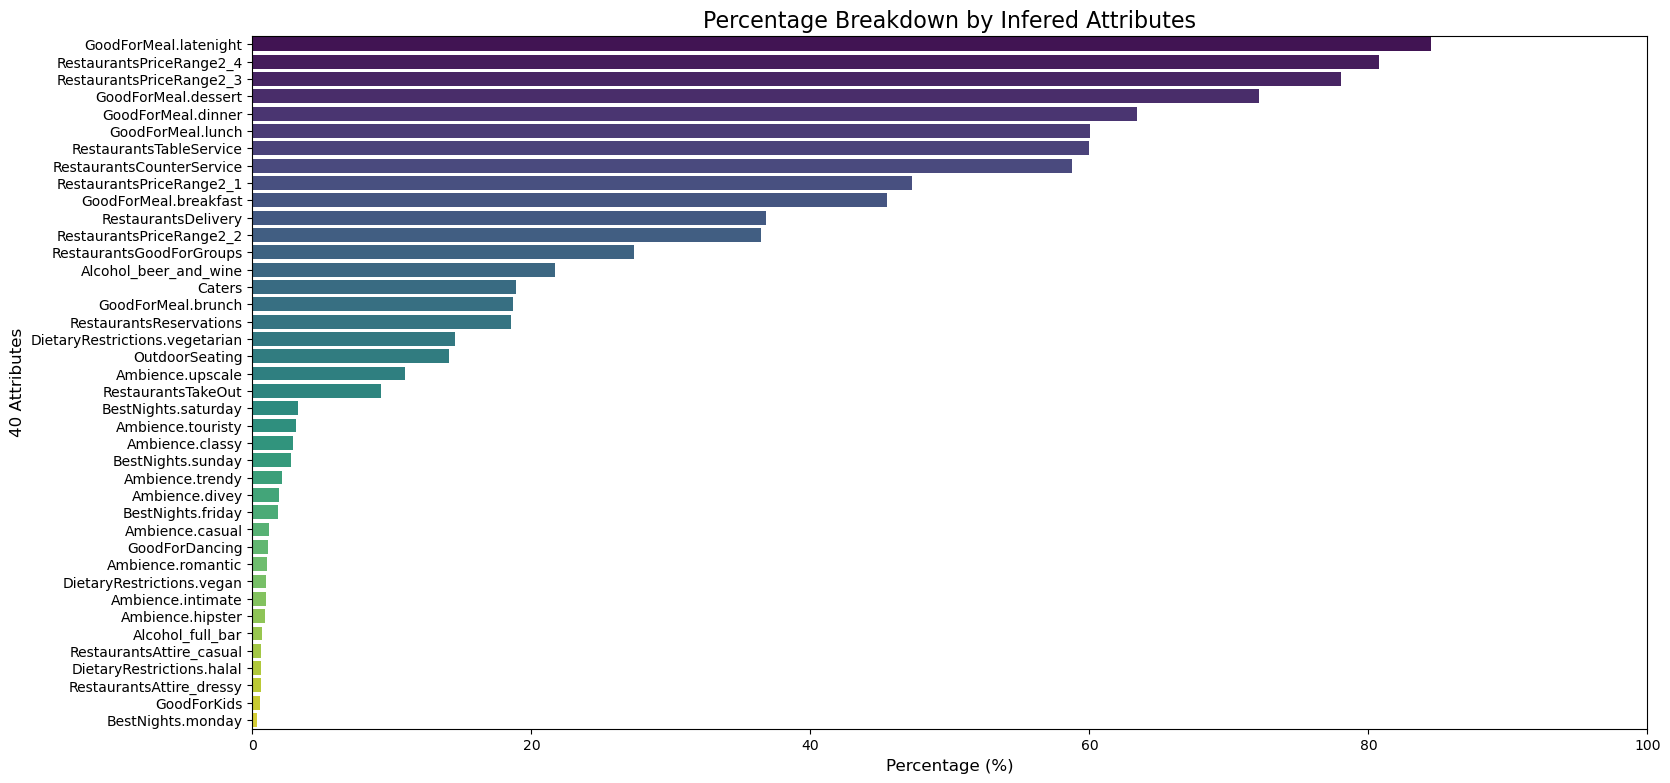

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 9))

sns.barplot(x = df_sorted["Percentage_Predicted"].iloc[:40], y = df_sorted["Attribute"].iloc[:40], data=df_sorted.iloc[:40], palette='viridis')

plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('40 Attributes', fontsize=12)
plt.legend = False
plt.xlim(0, 100)

plt.title('Percentage Breakdown by Infered Attributes', fontsize=16)
plt.show()

## 1.3 Apply logic and show result

In [ ]:
condicion_1_0_or_1_1 = (attributes == 1)
condicion_0_1 = (attributes == 0) & (inferred_attributes == 1)

final_attributes = (condicion_1_0_or_1_1 | condicion_0_1).astype(int)

In [ ]:
final_attributes

,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.street,BusinessParking.validated,BusinessParking.lot,BusinessParking.valet,BikeParking,RestaurantsPriceRange2_1,...,AgesAllowed_18plus,AgesAllowed_21plus,AgesAllowed_allages,DietaryRestrictions.dairy-free,DietaryRestrictions.gluten-free,DietaryRestrictions.vegan,DietaryRestrictions.halal,DietaryRestrictions.soy-free,DietaryRestrictions.vegetarian,AcceptsInsurance
0,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51217,1,0,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
51218,0,1,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
51219,1,0,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
51220,1,0,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


# 2. categories

## 2.1 Apply inferred_function

In [ ]:
categories

,Acai_Bowls,Active_Life,Adult_Entertainment,Afghan,African,Airport_Lounges,American_(New),American_(Traditional),Antiques,Appliances,...,Vietnamese,Waffles,Wedding_Planning,Whiskey_Bars,Wholesalers,Wine_&_Spirits,Wine_Bars,Wine_Tasting_Room,Wineries,Wraps
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
hypothesis_categories = {
    'Acai_Bowls': "This business is an Açaí Bowls establishment.",
    'Active_Life': "This business belongs to the Active Life category.",
    'Adult_Entertainment': "This business is an Adult Entertainment venue.",
    'Afghan': "This business serves Afghan cuisine.",
    'African': "This business serves African cuisine.",
    'Airport_Lounges': "This business is an Airport Lounge.",
    'American_(New)': "This business serves New American cuisine.",
    'American_(Traditional)': "This business serves Traditional American cuisine.",
    'Antiques': "This business sells Antiques.",
    'Appliances': "This business sells Appliances.",
    'Arabic': "This business serves Arabic cuisine.",
    'Arcades': "This business is an Arcade.",
    'Argentine': "This business serves Argentine cuisine.",
    'Armenian': "This business serves Armenian cuisine.",
    'Art_Galleries': "This business is an Art Gallery.",
    'Arts_&_Crafts': "This business sells Arts & Crafts.",
    'Arts_&_Entertainment': "This business belongs to the Arts & Entertainment category.",
    'Asian_Fusion': "This business serves Asian Fusion cuisine.",
    'Australian': "This business serves Australian cuisine.",
    'Austrian': "This business serves Austrian cuisine.",
    'Auto_Repair': "This business provides Auto Repair services.",
    'Automotive': "This business belongs to the Automotive category.",
    'Bagels': "This business sells Bagels.",
    'Bakeries': "This business is a Bakery.",
    'Bangladeshi': "This business serves Bangladeshi cuisine.",
    'Bar_Crawl': "This business organizes or is part of a Bar Crawl.",
    'Barbeque': "This business serves Barbeque.",
    'Bars': "This business is a Bar.",
    'Bartenders': "This business provides Bartender services.",
    'Basque': "This business serves Basque cuisine.",
    'Beaches': "This business is located at or related to Beaches.",
    'Bed_&_Breakfast': "This business is a Bed & Breakfast.",
    'Beer': "This business sells Beer.",
    'Beer_Bar': "This business is a Beer Bar.",
    'Beer_Gardens': "This business is a Beer Garden.",
    'Belgian': "This business serves Belgian cuisine.",
    'Beverage_Store': "This business is a Beverage Store.",
    'Bike_Rentals': "This business offers Bike Rentals.",
    'Bistros': "This business is a Bistro.",
    'Boating': "This business offers Boating activities.",
    'Books': "This business sells Books.",
    'Bookstores': "This business is a Bookstore.",
    'Bowling': "This business is a Bowling alley.",
    'Brasseries': "This business is a Brasserie.",
    'Brazilian': "This business serves Brazilian cuisine.",
    'Breakfast_&_Brunch': "This business serves Breakfast & Brunch.",
    'Breweries': "This business is a Brewery.",
    'Brewpubs': "This business is a Brewpub.",
    'British': "This business serves British cuisine.",
    'Bubble_Tea': "This business sells Bubble Tea.",
    'Buffets': "This business is a Buffet.",
    'Burgers': "This business serves Burgers.",
    'Burmese': "This business serves Burmese cuisine.",
    'Butcher': "This business is a Butcher shop.",
    'Cabaret': "This business is a Cabaret.",
    'Cafes': "This business is a Cafe.",
    'Cafeteria': "This business is a Cafeteria.",
    'Cajun/Creole': "This business serves Cajun/Creole cuisine.",
    'Cambodian': "This business serves Cambodian cuisine.",
    'Canadian_(New)': "This business serves New Canadian cuisine.",
    'Candy_Stores': "This business is a Candy Store.",
    'Cantonese': "This business serves Cantonese cuisine.",
    'Car_Dealers': "This business is a Car Dealer.",
    'Caribbean': "This business serves Caribbean cuisine.",
    'Casinos': "This business is a Casino.",
    'Champagne_Bars': "This business is a Champagne Bar.",
    'Cheese_Shops': "This business is a Cheese Shop.",
    'Cheesesteaks': "This business serves Cheesesteaks.",
    'Chicken_Shop': "This business is a Chicken Shop.",
    'Chicken_Wings': "This business serves Chicken Wings.",
    'Chinese': "This business serves Chinese cuisine.",
    'Chocolatiers_&_Shops': "This business is a Chocolatier & Shop.",
    'Churches': "This business is a Church.",
    'Cideries': "This business is a Cidery.",
    'Cigar_Bars': "This business is a Cigar Bar.",
    'Cinema': "This business is a Cinema.",
    'Cocktail_Bars': "This business is a Cocktail Bar.",
    'Coffee_&_Tea': "This business serves Coffee & Tea.",
    'Coffee_Roasteries': "This business is a Coffee Roastery.",
    'Colombian': "This business serves Colombian cuisine.",
    'Comedy_Clubs': "This business is a Comedy Club.",
    'Comfort_Food': "This business serves Comfort Food.",
    'Community_Service/Non-Profit': "This business is a Community Service/Non-Profit organization.",
    'Convenience_Stores': "This business is a Convenience Store.",
    'Cooking_Classes': "This business offers Cooking Classes.",
    'Country_Clubs': "This business is a Country Club.",
    'Creperies': "This business serves Crepes.",
    'Cuban': "This business serves Cuban cuisine.",
    'Cupcakes': "This business sells Cupcakes.",
    'Custom_Cakes': "This business creates Custom Cakes.",
    'Czech': "This business serves Czech cuisine.",
    'Dance_Clubs': "This business is a Dance Club.",
    'Delicatessen': "This business is a Delicatessen.",
    'Delis': "This business is a Deli.",
    'Desserts': "This business serves Desserts.",
    'Dim_Sum': "This business serves Dim Sum.",
    'Diners': "This business is a Diner.",
    'Dinner_Theater': "This business offers Dinner Theater.",
    'Distilleries': "This business is a Distillery.",
    'Dive_Bars': "This business is a Dive Bar.",
    'Do-It-Yourself_Food': "This business offers Do-It-Yourself Food experiences.",
    'Dominican': "This business serves Dominican cuisine.",
    'Donairs': "This business serves Donairs.",
    'Donuts': "This business sells Donuts.",
    'Eatertainment': "This business belongs to the Eatertainment category.",
    'Egyptian': "This business serves Egyptian cuisine.",
    'Empanadas': "This business serves Empanadas.",
    'Ethiopian': "This business serves Ethiopian cuisine.",
    'Ethnic_Food': "This business serves Ethnic Food.",
    'Ethnic_Grocery': "This business is an Ethnic Grocery store.",
    'Falafel': "This business serves Falafel.",
    'Farmers_Market': "This business is a Farmers Market.",
    'Farms': "This business is a Farm.",
    'Fashion': "This business belongs to the Fashion category.",
    'Fast_Food': "This business serves Fast Food.",
    'Filipino': "This business serves Filipino cuisine.",
    'Fish_&_Chips': "This business serves Fish & Chips.",
    'Fishing': "This business offers Fishing activities.",
    'Fitness_&_Instruction': "This business provides Fitness & Instruction.",
    'Fondue': "This business serves Fondue.",
    'Food_Court': "This business is a Food Court.",
    'Food_Delivery_Services': "This business provides Food Delivery Services.",
    'Food_Stands': "This business is a Food Stand.",
    'Food_Trucks': "This business is a Food Truck.",
    'French': "This business serves French cuisine.",
    'Fruits_&_Veggies': "This business sells Fruits & Veggies.",
    'Gas_Stations': "This business is a Gas Station.",
    'Gastropubs': "This business is a Gastropub.",
    'Gay_Bars': "This business is a Gay Bar.",
    'Gelato': "This business sells Gelato.",
    'German': "This business serves German cuisine.",
    'Gluten-Free': "This business offers Gluten-Free options.",
    'Golf': "This business offers Golf.",
    'Greek': "This business serves Greek cuisine.",
    'Grocery': "This business is a Grocery store.",
    'Gyms': "This business is a Gym.",
    'Haitian': "This business serves Haitian cuisine.",
    'Halal': "This business serves Halal food.",
    'Hawaiian': "This business serves Hawaiian cuisine.",
    'Health_Markets': "This business is a Health Market.",
    'Herbs_&_Spices': "This business sells Herbs & Spices.",
    'Himalayan/Nepalese': "This business serves Himalayan/Nepalese cuisine.",
    'Home_&_Garden': "This business belongs to the Home & Garden category.",
    'Honduran': "This business serves Honduran cuisine.",
    'Hong_Kong_Style_Cafe': "This business is a Hong Kong Style Cafe.",
    'Hookah_Bars': "This business is a Hookah Bar.",
    'Hot_Dogs': "This business serves Hot Dogs.",
    'Hot_Pot': "This business serves Hot Pot.",
    'Hotels': "This business is a Hotel.",
    'Hotels_&_Travel': "This business belongs to the Hotels & Travel category.",
    'Hungarian': "This business serves Hungarian cuisine.",
    'Iberian': "This business serves Iberian cuisine.",
    'Ice_Cream_&_Frozen_Yogurt': "This business sells Ice Cream & Frozen Yogurt.",
    'Imported_Food': "This business sells Imported Food.",
    'Indian': "This business serves Indian cuisine.",
    'Indonesian': "This business serves Indonesian cuisine.",
    'Indoor_Playcentre': "This business is an Indoor Playcentre.",
    'International': "This business serves International cuisine.",
    'International_Grocery': "This business is an International Grocery store.",
    'Internet_Cafes': "This business is an Internet Cafe.",
    'Irish': "This business serves Irish cuisine.",
    'Irish_Pub': "This business is an Irish Pub.",
    'Italian': "This business serves Italian cuisine.",
    'Izakaya': "This business is an Izakaya.",
    'Japanese': "This business serves Japanese cuisine.",
    'Japanese_Curry': "This business serves Japanese Curry.",
    'Jazz_&_Blues': "This business offers Jazz & Blues music.",
    'Juice_Bars_&_Smoothies': "This business is a Juice Bar & Smoothies shop.",
    'Karaoke': "This business offers Karaoke.",
    'Kebab': "This business serves Kebab.",
    'Kids_Activities': "This business offers Kids Activities.",
    'Kitchen_&_Bath': "This business specializes in Kitchen & Bath.",
    'Kombucha': "This business sells Kombucha.",
    'Korean': "This business serves Korean cuisine.",
    'Kosher': "This business serves Kosher food.",
    'Laotian': "This business serves Laotian cuisine.",
    'Latin_American': "This business serves Latin American cuisine.",
    'Lebanese': "This business serves Lebanese cuisine.",
    'Leisure_Centers': "This business is a Leisure Center.",
    'Live/Raw_Food': "This business serves Live/Raw Food.",
    'Local_Flavor': "This business offers Local Flavor.",
    'Local_Services': "This business provides Local Services.",
    'Lounges': "This business is a Lounge.",
    'Macarons': "This business sells Macarons.",
    'Mags': "This business sells Magazines.",
    'Malaysian': "This business serves Malaysian cuisine.",
    'Meat_Shops': "This business is a Meat Shop.",
    'Mediterranean': "This business serves Mediterranean cuisine.",
    'Mexican': "This business serves Mexican cuisine.",
    'Middle_Eastern': "This business serves Middle Eastern cuisine.",
    'Mini_Golf': "This business offers Mini Golf.",
    'Modern_European': "This business serves Modern European cuisine.",
    'Mongolian': "This business serves Mongolian cuisine.",
    'Moroccan': "This business serves Moroccan cuisine.",
    'Museums': "This business is a Museum.",
    'Music_&_Video': "This business sells Music & Video.",
    'Music_Venues': "This business is a Music Venue.",
    'Musicians': "This business provides Musician services.",
    'New_Mexican_Cuisine': "This business serves New Mexican Cuisine.",
    'Nicaraguan': "This business serves Nicaraguan cuisine.",
    'Nightlife': "This business belongs to the Nightlife category.",
    'Noodles': "This business serves Noodles.",
    'Organic_Stores': "This business is an Organic Store.",
    'Pakistani': "This business serves Pakistani cuisine.",
    'Pan_Asian': "This business serves Pan Asian cuisine.",
    'Pancakes': "This business serves Pancakes.",
    'Parks': "This business is a Park.",
    'Pasta_Shops': "This business is a Pasta Shop.",
    'Patisserie/Cake_Shop': "This business is a Patisserie/Cake Shop.",
    'Performing_Arts': "This business offers Performing Arts.",
    'Persian/Iranian': "This business serves Persian/Iranian cuisine.",
    'Peruvian': "This business serves Peruvian cuisine.",
    'Pet_Adoption': "This business facilitates Pet Adoption.",
    'Pets': "This business sells Pets or pet supplies.",
    'Piano_Bars': "This business is a Piano Bar.",
    'Pizza': "This business serves Pizza.",
    'Poke': "This business serves Poke.",
    'Polish': "This business serves Polish cuisine.",
    'Pool_&_Billiards': "This business offers Pool & Billiards.",
    'Pool_Halls': "This business is a Pool Hall.",
    'Pop-Up_Restaurants': "This business is a Pop-Up Restaurant.",
    'Pop-up_Shops': "This business is a Pop-up Shop.",
    'Popcorn_Shops': "This business is a Popcorn Shop.",
    'Portuguese': "This business serves Portuguese cuisine.",
    'Poutineries': "This business serves Poutineries.",
    'Pretzels': "This business sells Pretzels.",
    'Public_Markets': "This business is a Public Market.",
    'Pubs': "This business is a Pub.",
    'Puerto_Rican': "This business serves Puerto Rican cuisine.",
    'Ramen': "This business serves Ramen.",
    'Recreation_Centers': "This business is a Recreation Center.",
    'Religious_Organizations': "This business is a Religious Organization.",
    'Resorts': "This business is a Resort.",
    'Russian': "This business serves Russian cuisine.",
    'Salad': "This business serves Salad.",
    'Salvadoran': "This business serves Salvadoran cuisine.",
    'Sandwiches': "This business serves Sandwiches.",
    'Scandinavian': "This business serves Scandinavian cuisine.",
    'Scottish': "This business serves Scottish cuisine.",
    'Seafood': "This business serves Seafood.",
    'Seafood_Markets': "This business is a Seafood Market.",
    'Senegalese': "This business serves Senegalese cuisine.",
    'Shanghainese': "This business serves Shanghainese cuisine.",
    'Shaved_Ice': "This business sells Shaved Ice.",
    'Shaved_Snow': "This business sells Shaved Snow.",
    'Sicilian': "This business serves Sicilian cuisine.",
    'Singaporean': "This business serves Singaporean cuisine.",
    'Skating_Rinks': "This business is a Skating Rink.",
    'Smokehouse': "This business is a Smokehouse.",
    'Social_Clubs': "This business is a Social Club.",
    'Soul_Food': "This business serves Soul Food.",
    'Soup': "This business serves Soup.",
    'South_African': "This business serves South African cuisine.",
    'Southern': "This business serves Southern cuisine.",
    'Spanish': "This business serves Spanish cuisine.",
    'Speakeasies': "This business is a Speakeasy.",
    'Sporting_Goods': "This business sells Sporting Goods.",
    'Sports_Bars': "This business is a Sports Bar.",
    'Sports_Clubs': "This business is a Sports Club.",
    'Steakhouses': "This business is a Steakhouse.",
    'Street_Vendors': "This business is a Street Vendor.",
    'Sushi_Bars': "This business is a Sushi Bar.",
    'Syrian': "This business serves Syrian cuisine.",
    'Szechuan': "This business serves Szechuan cuisine.",
    'Tabletop_Games': "This business offers Tabletop Games.",
    'Tacos': "This business serves Tacos.",
    'Taiwanese': "This business serves Taiwanese cuisine.",
    'Tapas_Bars': "This business is a Tapas Bar.",
    'Tapas/Small_Plates': "This business serves Tapas/Small Plates.",
    'Tea_Rooms': "This business is a Tea Room.",
    'Tennis': "This business offers Tennis facilities.",
    'Teppanyaki': "This business serves Teppanyaki.",
    'Tex-Mex': "This business serves Tex-Mex cuisine.",
    'Thai': "This business serves Thai cuisine.",
    'Themed_Cafes': "This business is a Themed Cafe.",
    'Tiki_Bars': "This business is a Tiki Bar.",
    'Tobacco_Shops': "This business is a Tobacco Shop.",
    'Travel_Services': "This business provides Travel Services.",
    'Trinidadian': "This business serves Trinidadian cuisine.",
    'Turkish': "This business serves Turkish cuisine.",
    'Tuscan': "This business serves Tuscan cuisine.",
    'Ukrainian': "This business serves Ukrainian cuisine.",
    'Uzbek': "This business serves Uzbek cuisine.",
    'Vegan': "This business serves Vegan food.",
    'Vegetarian': "This business serves Vegetarian food.",
    'Venezuelan': "This business serves Venezuelan cuisine.",
    'Vietnamese': "This business serves Vietnamese cuisine.",
    'Waffles': "This business serves Waffles.",
    'Wedding_Planning': "This business offers Wedding Planning services.",
    'Whiskey_Bars': "This business is a Whiskey Bar.",
    'Wholesalers': "This business is a Wholesaler.",
    'Wine_&_Spirits': "This business sells Wine & Spirits.",
    'Wine_Bars': "This business is a Wine Bar.",
    'Wine_Tasting_Room': "This business is a Wine Tasting Room.",
    'Wineries': "This business is a Winery.",
    'Wraps': "This business serves Wraps."
}

In [ ]:
inferred_categories = inferred_function(hypothesis_categories, reviews_embedding)

In [ ]:
inferred_categories

,Acai_Bowls,Active_Life,Adult_Entertainment,Afghan,African,Airport_Lounges,American_(New),American_(Traditional),Antiques,Appliances,...,Vietnamese,Waffles,Wedding_Planning,Whiskey_Bars,Wholesalers,Wine_&_Spirits,Wine_Bars,Wine_Tasting_Room,Wineries,Wraps
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51217,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
51218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51219,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
51220,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.2 Show results

In [ ]:
total_columns = categories.columns
results = []

for column in total_columns:
    y_tab = categories[column]
    y_inferred = inferred_categories[column]

    predicted = ((y_inferred != y_tab) & y_inferred).sum()
    non_predicted = ((y_inferred != y_tab) & y_tab).sum()

    results.append({
        "Categorie": column,
        "New_values_predicted": predicted,
        "Non_Predicted": non_predicted,
        "Percentage_Predicted": round(predicted / len(y_inferred) * 100, 2),
        "Percentage_Non_Predicted": round(non_predicted / len(y_inferred) * 100, 2)
    })

df_results = pd.DataFrame(results)

In [ ]:
df_results.sort_values("New_values_predicted", ascending=False)

,Categorie,New_values_predicted,Non_Predicted,Percentage_Predicted,Percentage_Non_Predicted
100,Do-It-Yourself_Food,45506,3,88.84,0.01
180,Local_Flavor,42587,40,83.14,0.08
280,Tuscan,40234,0,78.55,0.00
253,Southern,38610,30,75.38,0.06
6,American_(New),36793,638,71.83,1.25
...,...,...,...,...,...
21,Automotive,0,254,0.00,0.50
255,Speakeasies,0,13,0.00,0.03
260,Street_Vendors,0,252,0.00,0.49
270,Tennis,0,7,0.00,0.01


In [ ]:
df_sorted = df_results.sort_values("New_values_predicted", ascending=False)
x = range(len(df_sorted["Categorie"]))

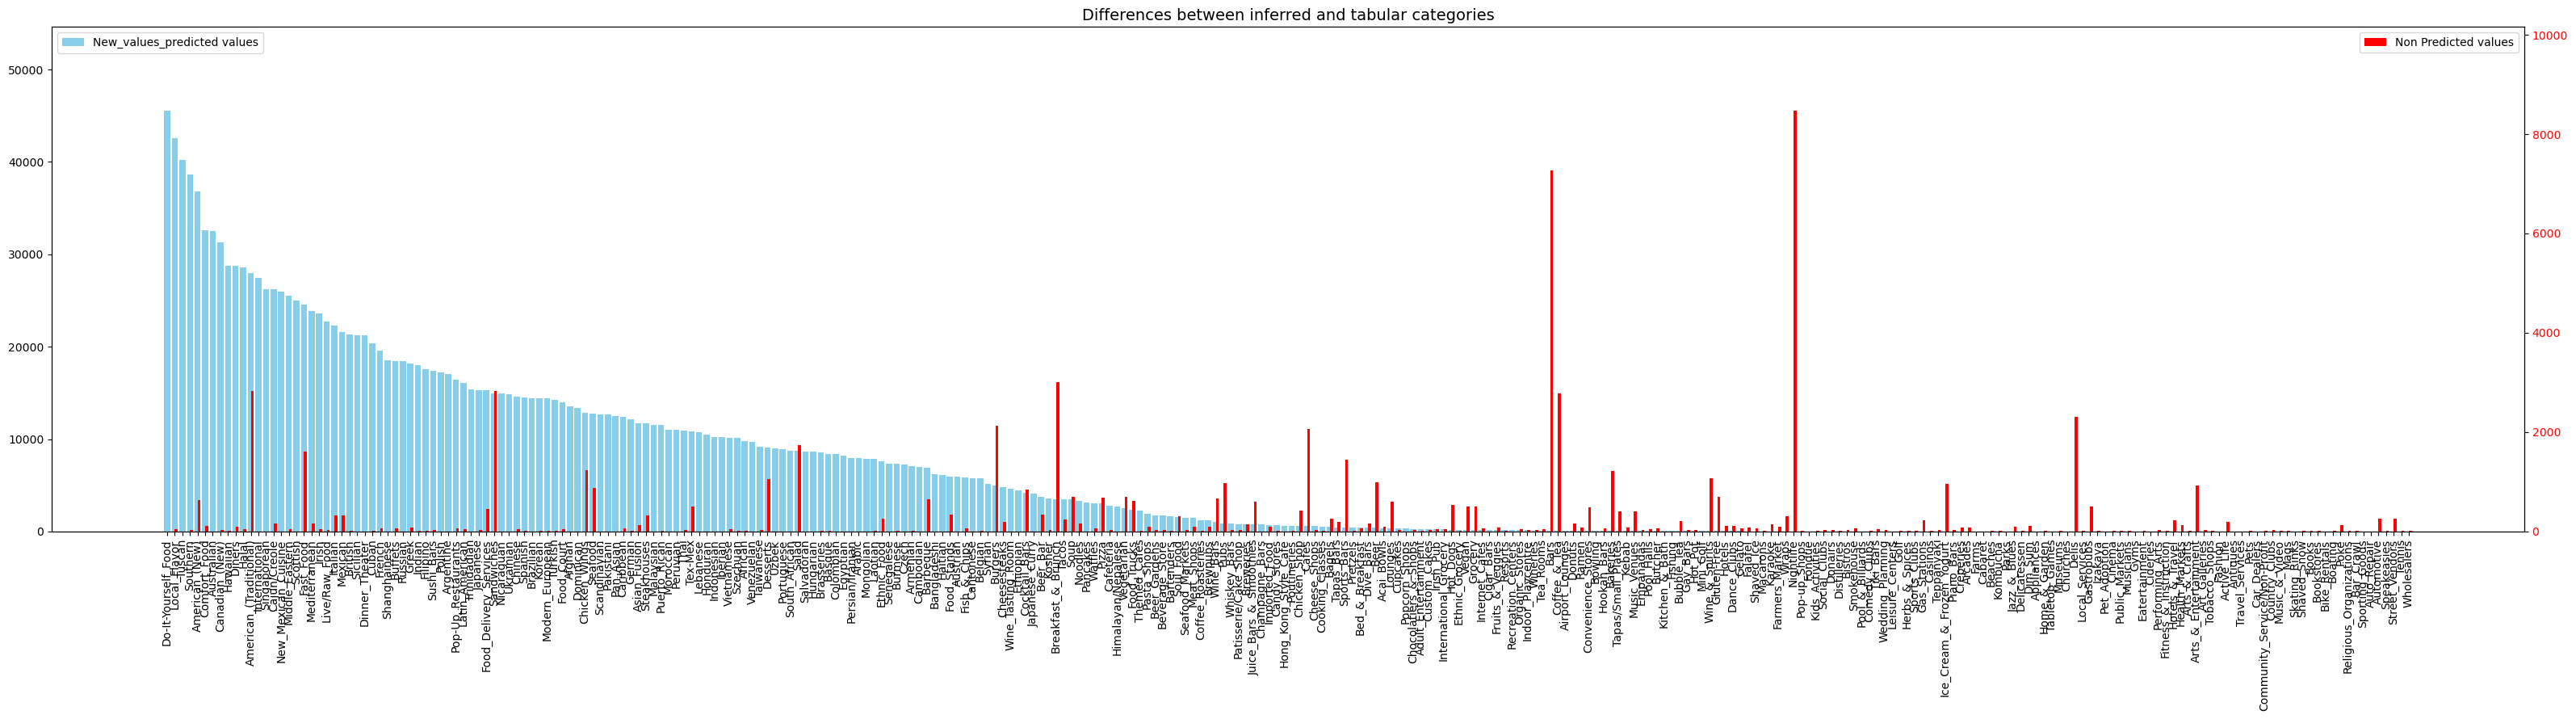

In [ ]:
fig, ax1 = plt.subplots(figsize=(32, 9))

bars = ax1.bar(x, df_sorted["New_values_predicted"], color='skyblue', label='New_values_predicted values')
ax1.set_ylim(0, max(df_sorted["New_values_predicted"]) * 1.2)

ax2 = ax1.twinx()
bars2 = ax2.bar([i + 0.2 for i in x], df_sorted["Non_Predicted"], width=0.4, color='red', label='Non Predicted values')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(df_sorted["Non_Predicted"]) * 1.2)

ax1.set_xticks(x)
ax1.set_xticklabels(df_sorted["Categorie"], rotation=90)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Differences between inferred and tabular categories", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\Antonio Búa Pita\AppData\Local\Temp\ipykernel_4836\3387673334.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = df_sorted["Percentage_Predicted"].iloc[:80], y = df_sorted["Categorie"].iloc[:80], data=df_sorted.iloc[:80], palette='viridis')


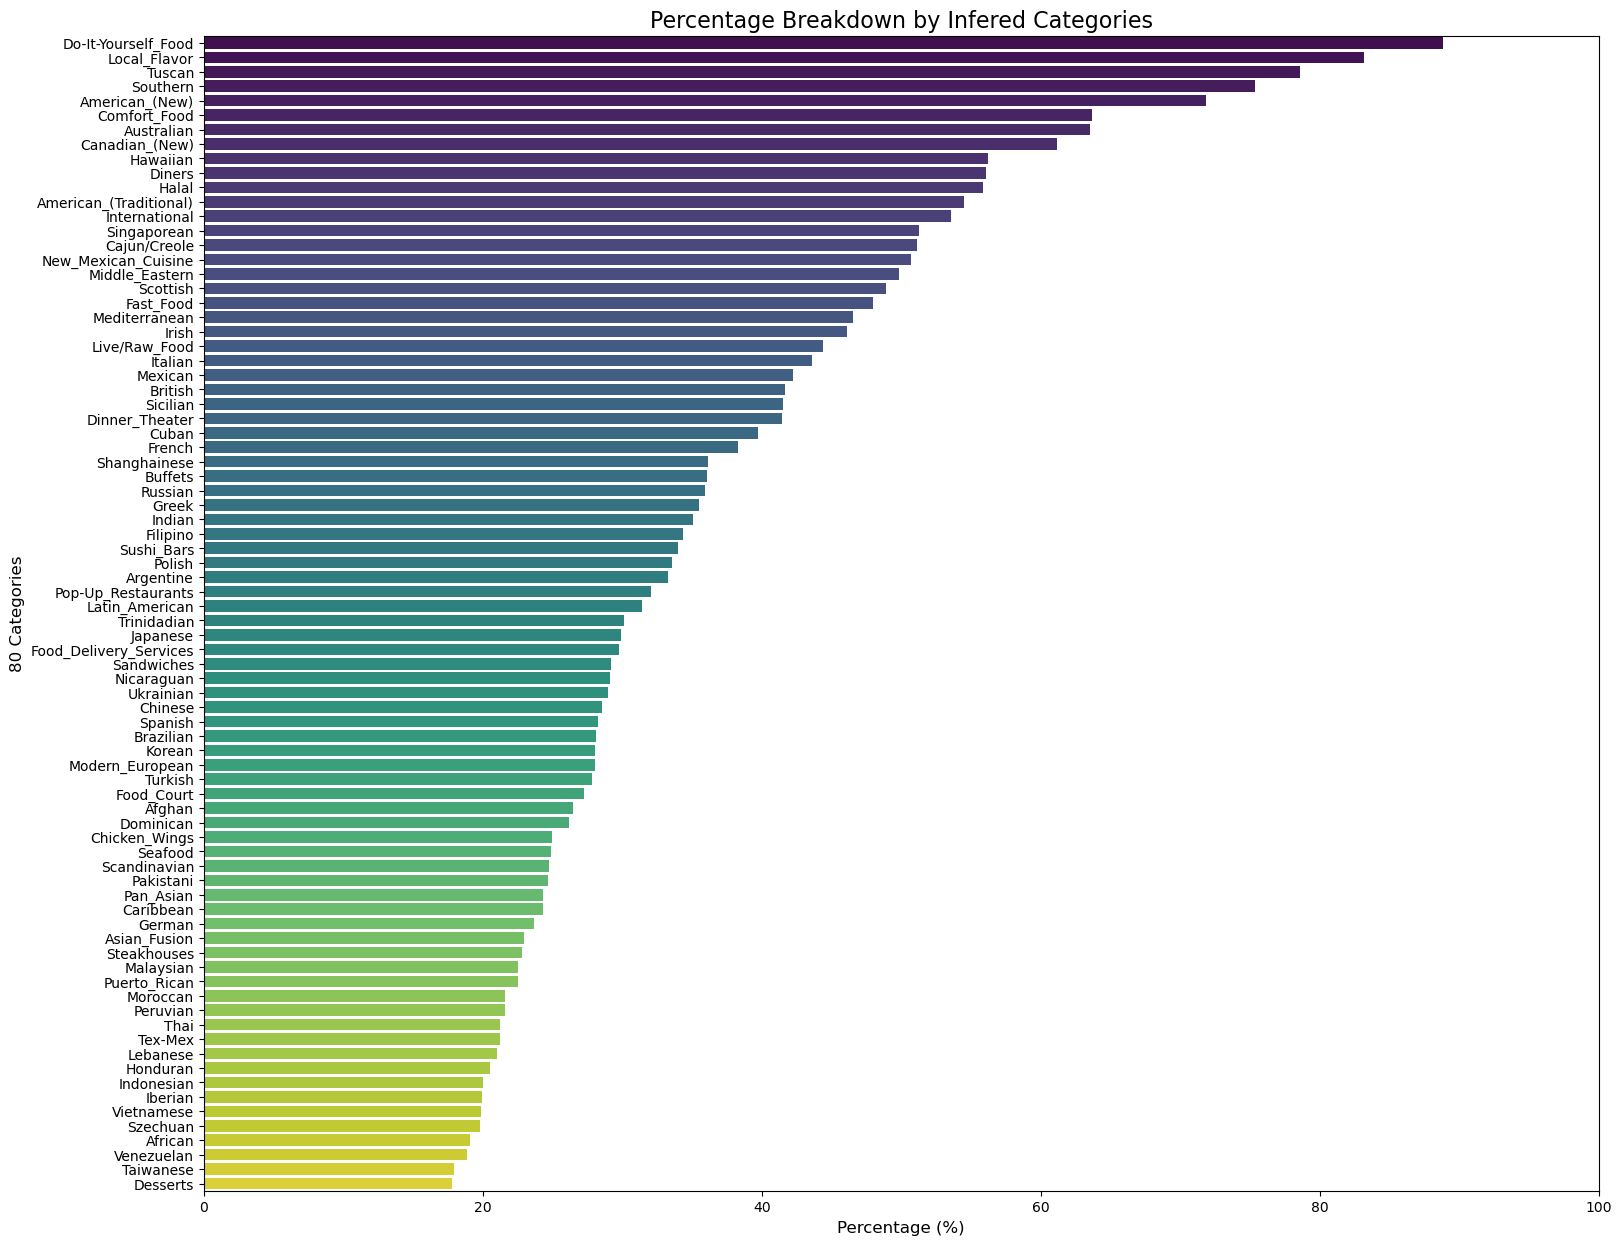

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 15))

sns.barplot(x = df_sorted["Percentage_Predicted"].iloc[:80], y = df_sorted["Categorie"].iloc[:80], data=df_sorted.iloc[:80], palette='viridis')

plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('80 Categories', fontsize=12)
plt.legend = False
plt.xlim(0, 100)

plt.title('Percentage Breakdown by Infered Categories', fontsize=16)
plt.show()

## 2.3 Apply logic and show result

In [ ]:
condicion_1_0_or_1_1 = (categories == 1)
condicion_0_1 = (categories == 0) & (inferred_categories == 1)

final_categories = (condicion_1_0_or_1_1 | condicion_0_1).astype(int)

In [ ]:
final_categories

,Acai_Bowls,Active_Life,Adult_Entertainment,Afghan,African,Airport_Lounges,American_(New),American_(Traditional),Antiques,Appliances,...,Vietnamese,Waffles,Wedding_Planning,Whiskey_Bars,Wholesalers,Wine_&_Spirits,Wine_Bars,Wine_Tasting_Room,Wineries,Wraps
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51217,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
51218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51219,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
51220,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3. Joining files and exporting them

In [ ]:
features_multihot = pd.concat([final_attributes, final_categories], axis = 1)

In [ ]:
features_multihot

,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.street,BusinessParking.validated,BusinessParking.lot,BusinessParking.valet,BikeParking,RestaurantsPriceRange2_1,...,Vietnamese,Waffles,Wedding_Planning,Whiskey_Bars,Wholesalers,Wine_&_Spirits,Wine_Bars,Wine_Tasting_Room,Wineries,Wraps
0,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51217,1,0,1,0,0,0,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0
51218,0,1,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
51219,1,0,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
51220,1,0,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
features_text = features_multihot.astype(bool).apply(lambda row: ', '.join(features_multihot.columns[row.values]), axis=1)
features_text

0        BusinessParking.street, BikeParking, Restauran...
1        RestaurantsDelivery, OutdoorSeating, BusinessA...
2        RestaurantsDelivery, OutdoorSeating, BusinessA...
3        RestaurantsDelivery, OutdoorSeating, BusinessA...
4        RestaurantsDelivery, RestaurantsGoodForGroups,...
                               ...                        
51217    RestaurantsDelivery, BusinessAcceptsCreditCard...
51218    OutdoorSeating, BusinessAcceptsCreditCards, Bu...
51219    RestaurantsDelivery, BusinessAcceptsCreditCard...
51220    RestaurantsDelivery, BusinessAcceptsCreditCard...
51221    RestaurantsDelivery, RestaurantsPriceRange2_1,...
Length: 51222, dtype: object

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

features_emb = model.encode(features_text,
                               show_progress_bar = True)

Batches:   0%|          | 0/1601 [00:00<?, ?it/s]

In [ ]:
df_embeddings = pd.DataFrame(features_emb)
filename = "features_embeddings.parquet"
df_embeddings.to_parquet(filename, index = False)
print("Embeddings saved in", filename)

Embeddings saved in features_embeddings.parquet


In [ ]:
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.060994,-0.058731,0.046028,0.036130,-0.065391,0.036867,0.064709,-0.079463,-0.026856,-0.052672,...,0.041182,0.051266,0.042201,-0.052497,0.079242,0.026982,0.068166,0.049139,0.016757,0.032503
1,0.010512,-0.089916,0.032057,0.021424,-0.043168,0.030060,0.075820,-0.043214,-0.048110,-0.065397,...,-0.008394,-0.006778,0.077426,-0.040012,0.076159,0.028838,0.081807,0.063818,-0.027299,0.046949
2,0.023317,-0.080711,0.030814,0.023802,-0.090899,0.011449,0.044665,-0.080506,0.019608,-0.066450,...,0.043332,0.025916,0.040635,0.002920,0.102652,-0.016240,0.090398,0.037086,-0.005023,0.033053
3,0.019170,-0.087083,0.048138,0.023768,-0.037998,0.020741,0.087767,-0.038430,-0.048330,-0.067437,...,0.005777,-0.008103,0.084586,-0.046171,0.060110,0.033985,0.083894,0.057194,-0.002169,0.037805
4,0.034744,-0.053749,0.046861,0.014953,-0.082136,-0.011172,0.022656,-0.123831,-0.007462,-0.042297,...,0.017371,0.048241,0.043017,-0.024750,0.142087,-0.054897,0.074878,0.127000,0.030289,0.043886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51217,0.018252,-0.047564,0.015768,0.022423,-0.088184,0.049658,0.088180,-0.011617,-0.033635,-0.079844,...,-0.003270,0.043789,0.017808,-0.072441,0.095380,-0.010807,0.048599,0.108882,-0.029141,0.013239
51218,0.034479,-0.081635,0.032604,0.037508,0.000288,-0.002172,0.097170,-0.024591,-0.062036,-0.030207,...,0.004871,0.040735,0.001525,0.013739,0.040276,0.011924,0.045234,0.062330,-0.066561,0.018794
51219,0.063227,-0.093974,0.055289,0.041479,-0.077795,0.011989,0.025985,-0.078549,-0.005210,-0.071823,...,0.034478,0.041371,0.054273,-0.023738,0.116951,-0.027320,0.051742,0.052429,0.029465,-0.003259
51220,0.060787,-0.083616,0.033398,0.032383,-0.094560,0.002787,0.034497,-0.098552,-0.043841,-0.076714,...,0.028971,0.044418,0.041451,-0.047702,0.099419,0.005432,0.069191,0.056351,0.023409,0.033856
